# Surface Mining Screening

* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/products/gm_s2_annual/extents), 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc/extents), 
[wofs_ls_summary_annual](https://explorer.digitalearth.africa/products/wofs_ls_summary_annual/extents)

## Background

[Surface mining](https://americanmineservices.com/types-of-surface-mining) refers to the removal of the terrain surface to access minerals underneath. In particular, surface mining is used to retrieve sand, gravel, stones, coal, iron and other metals. Surface mining is often more cost-effective than gouging tunnels and subterranean shafts to access minerals underground.

Although surface mining contributes to the source of income for a country, these operations can result in deleterious impacts on farmlands, forests, and water bodies. Government officials are making efforts to identify areas of these mining activities. 

This notebook demonstrates a method for identifying areas of surface mining activity. The notebook combines methods based on vegetation loss and water detection. Although the notebook aids in detecting these areas, further verification by government agencies or institutions are required to validate the operations on the ground.

## Description

Surface mining operations often result in the clearing of vegetation and the development of water from the land. Using remote sensing images from [Sentinel-2 GEOMAD](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html) or [Sentinel-1](https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-1_specs.html), and DE Africa's [Water Observations from Space (WOfS)](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_WOfS_specs.html) product, this notebook screen areas where there is a possibility of surface mining. 

The notebook uses Normalised Difference Vegetation Index (for sentinel-2) or the Radar Vegetation Index (for sentinel-1) to determine vegetation loss, where loss occurs if the change in vegetation index is negative. DE Africa's WOfS product is used to identify water.

The final product identifies pixels that exhibit vegetation loss, and the presence of water.
In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

The notebook demonstrates how to:

1. Load data for a given location and time period
2. Calculate the vegetation change
3. Calculate the presence of water
4. Combine vegetation change and water extent change into one plot to show possible mining areas

***

## Getting started

### Load packages

In [1]:
# Import functions for this notebook
from Surface_mining_screening import (
    calculate_area_per_pixel,
    load_vector_file,
    process_data,
    calculate_vegetation_loss,
    plot_possible_mining,
    plot_vegetationloss_mining,
)

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The area of interest must be defined with a shapefile (`.shp`), a geojosn (`.geojson`), or a KML file (`.kml`).

The parameters are:

* `start_year`: The year to start the analysis
* `end_year`: The year to end the analysis
* `product` : whether oto use Sentinel-2 or sentinel-1 for the analysis, acceptable values are `'s2'` or `'s1'`
* `threhold`: The threshold to use for indentifying vegetaton loss, this can either be a float e.g. `-0.15`, or `'otsu'`, in which case the threshold will be automatically identified using the otsu method.
* `vector_file`: The file path and name of a vector file containing the extent. Can be a `.kml` file, or a `.shp` file.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of the Essen Apam Forest Reserve, Ghana, and uses the shapefile provided in **Supplementary Data**.

In [2]:
start_year = 2017
end_year = 2020
product= 's2'
threshold = -0.1
vector_file = "./data/Apam_forest.shp"

### View the area of interest defined by the vector file

In [3]:
gdf, geom = load_vector_file(vector_file)

Label(value='')

Map(center=[6.328635468846285, -1.8708615021743045], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Load and process data

This analysis uses two datasets:

* Sentinel-2 geomedians or Sentinel-1 backscatter for identifying vegetation loss
* Water Observations from Space (WOfS) for identifying water

If an area has experienced both vegetation loss and water presence, it may be related to surface mining activity. 

The function below loads Sentinel-2 or sentinel-1 and WOfS for the area of interest and does a number of cleaning and processing steps.  The function will also plot an RGB image for each year in the analysis

> Note, if the product used is Sentinel-1, this cell can take a few minutes to run as annual medians are calculated on-the-fly

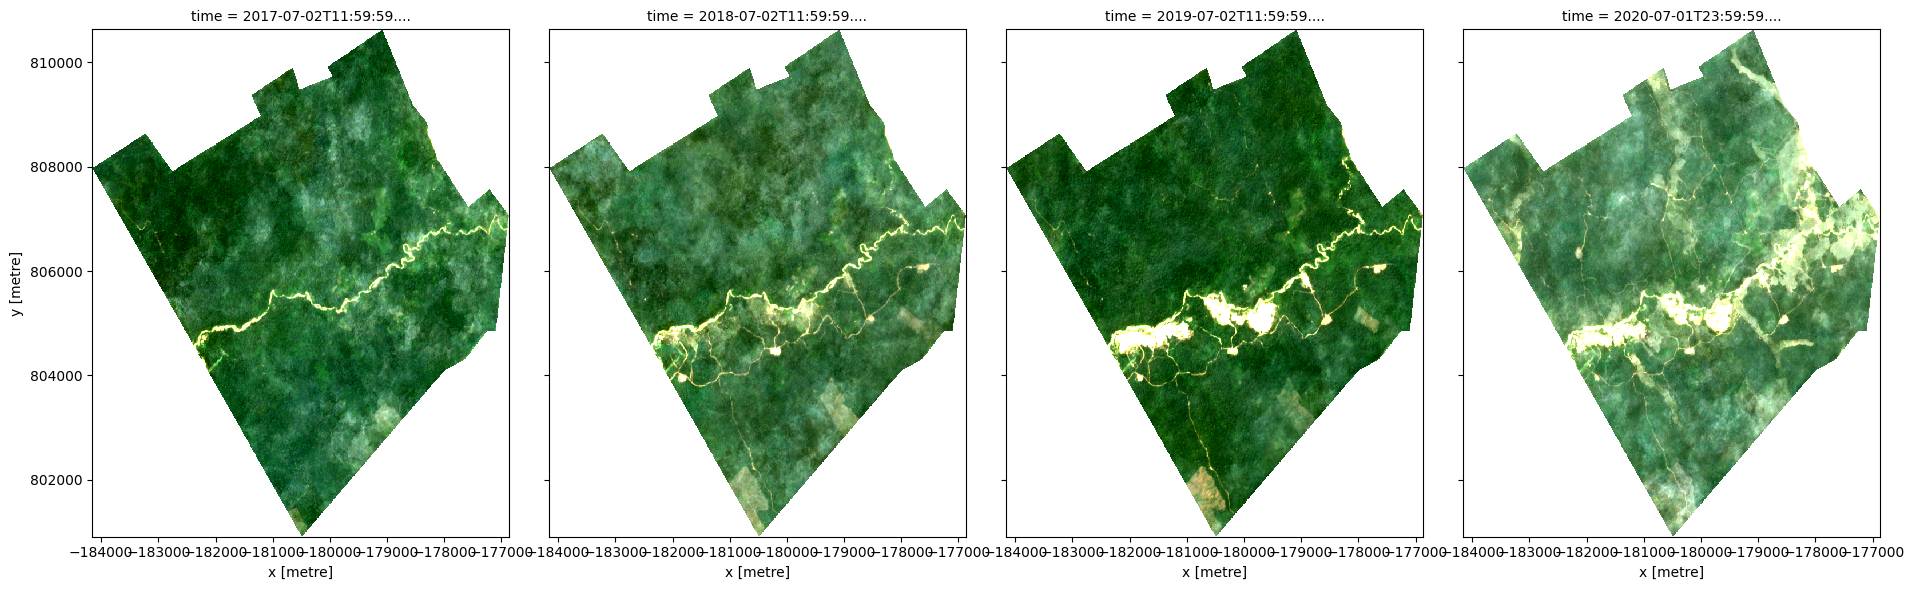

In [4]:
sentinel, wofs = process_data(gdf, geom, start_year, end_year, product=product)

## Calculate vegetation loss

The next function determines whether NDVI (or RVI) decreased between one year and the next. If so, the area experienced vegetation loss. Significant vegetation loss is determined using the `threshold` defined in `Analysis Parameters`. You may want to tune this threshold to better delineate the areas experiencing vegetation loss.

The function returns the annual vegetation loss (in square kilometres) and the total vegetation loss over all years of the analysis. It then plots the annual vegetation loss.

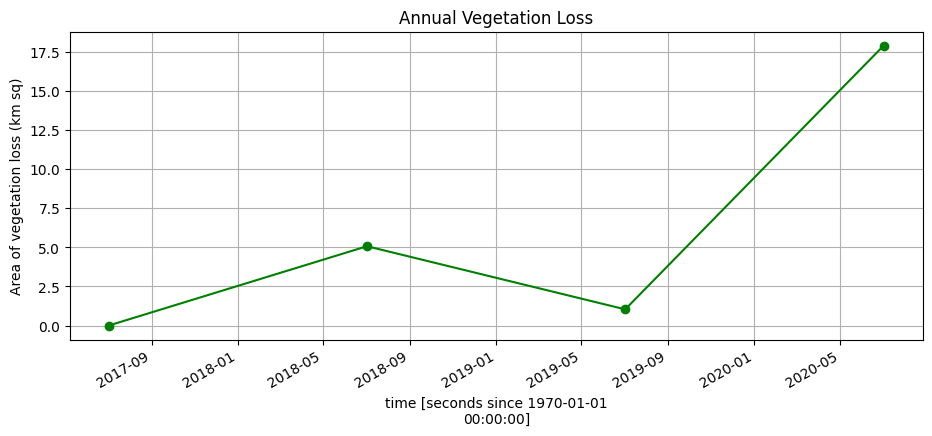

In [5]:
veg_loss_annual, veg_loss_all = calculate_vegetation_loss(sentinel, threshold=threshold, product=product)

## Determine possible mining areas

When water (WOfS) and vegetation loss are coincident, the area is classified as high-potential mining site.

Areas within 250 metres of a high-potential mining site where there was only vegetation loss are also considered to be possible mining sites.

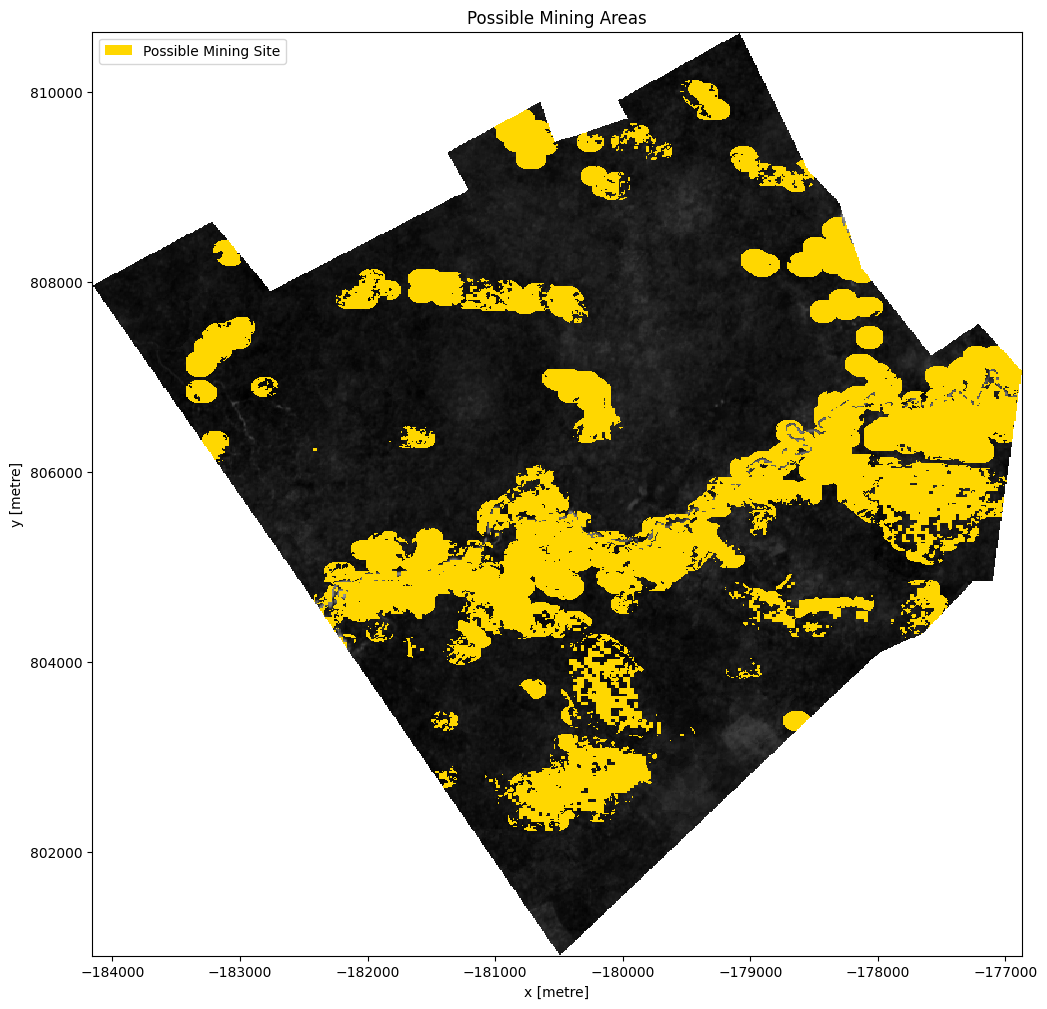

In [6]:
vegetation_loss_mining = plot_possible_mining(sentinel, veg_loss_all, wofs, product=product)

In [18]:
import rioxarray

vegetation_loss_mining.rio.to_raster('surface_mining.tif')

## Examine vegetation loss from possible mining each year

The final function compares the vegetation loss from possible mining to all vegetation loss each year, and builds a spatial plot showing the vegetation loss from possible mining each year.

                                            
Total Area(kmsq) of the vector file  36.2628
...................................................................
                                            2017       2018      2019  \
Any Vegetation Loss(kmsq)                    0.0   5.065500  1.032800   
Any Vegetation Loss(%)                       0.0  13.968861  2.848098   
Vegetation Loss from Possible Mining(kmsq)   0.0   1.753300  0.933700   
Vegetation Loss from Possible Mining(%)      0.0   4.834982  2.574815   

                                                 2020  
Any Vegetation Loss(kmsq)                   17.886900  
Any Vegetation Loss(%)                      49.325755  
Vegetation Loss from Possible Mining(kmsq)   6.315000  
Vegetation Loss from Possible Mining(%)     17.414541  
...................................................................


<Figure size 1200x1200 with 0 Axes>

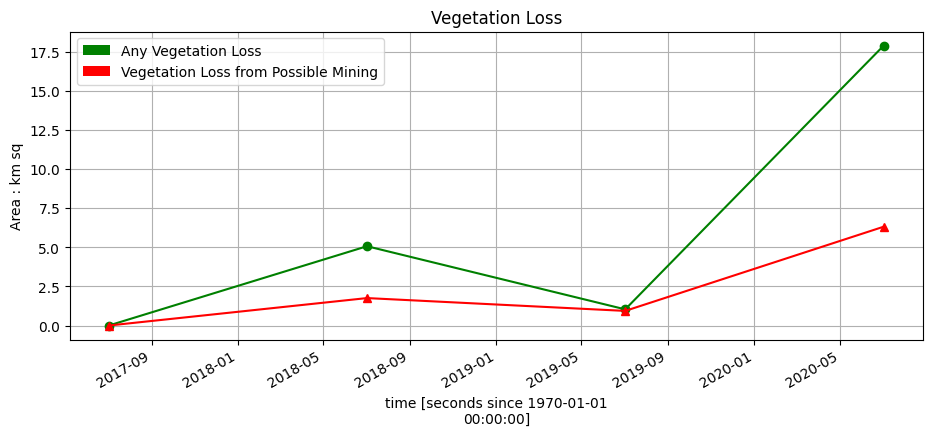

...................................................................


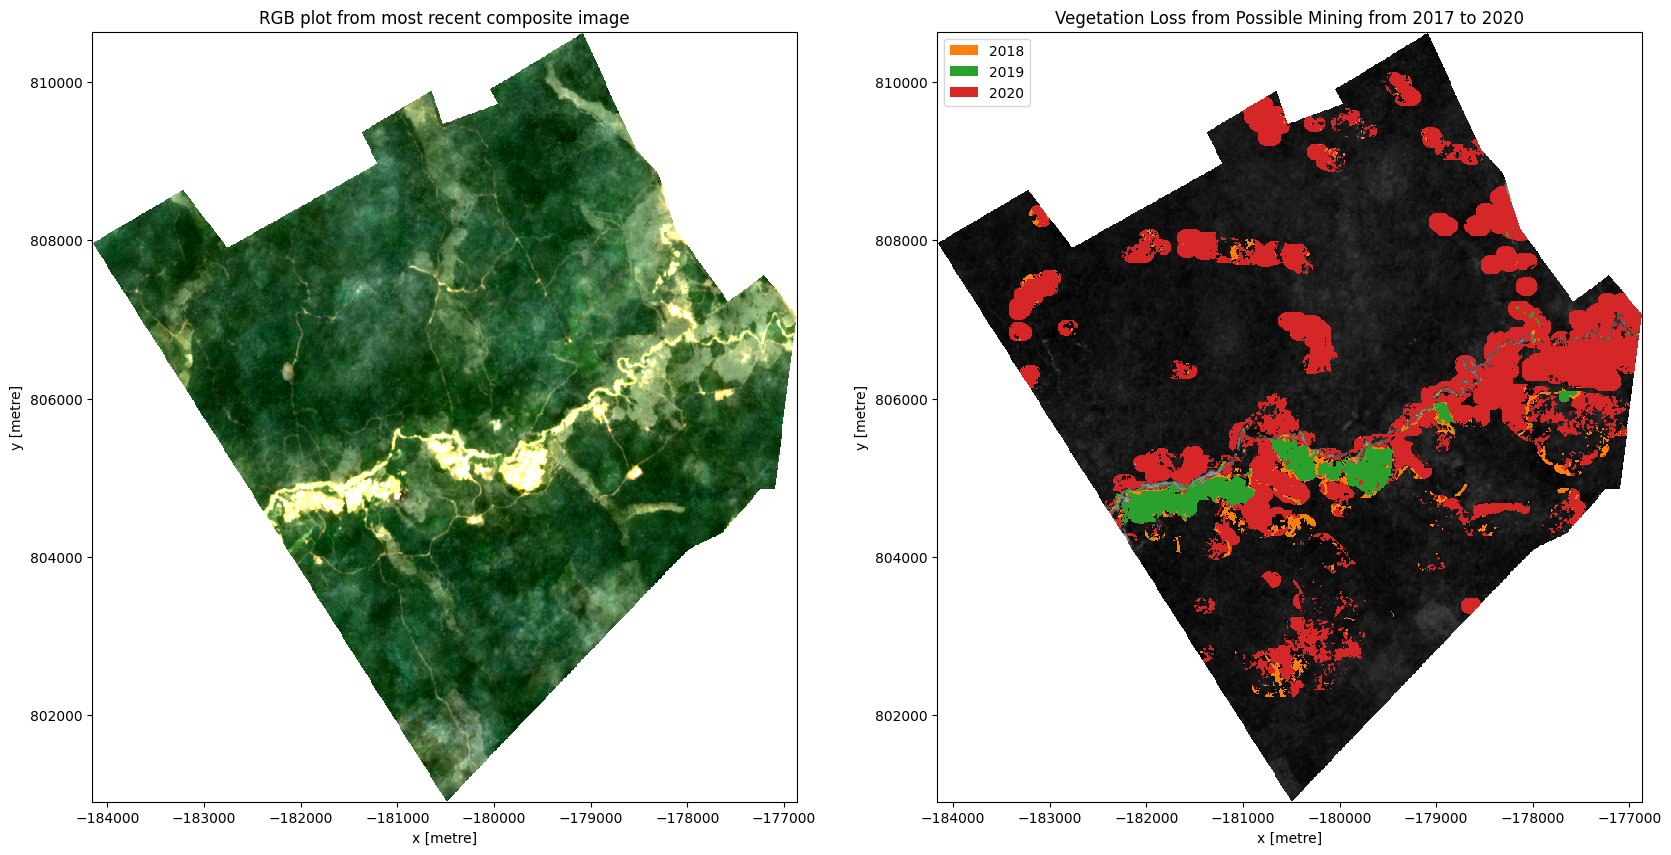

In [7]:
plot_vegetationloss_mining(sentinel, veg_loss_annual, vegetation_loss_mining, product=product)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [8]:
import datacube
print(datacube.__version__)

1.8.5


**Last Tested:**

In [9]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-09-21'